In [12]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.general.postprocessing.utils_metadata import regionprops_one_volume_one_channel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from segmentation.util.utils_pipeline import perform_post_processing_2d

In [2]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/project_pytest/project_config.yaml"
fname = "/home/charles/dlc_stacks/students-worm4-LOCAL/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

Project data for directory:
/home/charles/dlc_stacks/students-worm4-LOCAL 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     True
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



# Try to automatically resegment using a hierarchy of methods:

1. Initially, just gaussian fitting (already tried)
2. If that fails, use centroid motion?
3. If that fails, use inner-product 

Also, try to split triple-squished neurons

## First, reproduce the segmentation from the used settings


In [446]:
ind = 53
t = 2
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [447]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

In [448]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/718 [00:00<?, ?it/s]

IndexError: index 18 is out of bounds for axis 0 with size 18

In [10]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb85f57f850>

In [ ]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [51]:
# Get differences (should only be due to gaussian splitting initialization)
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values for {k[0]}: {v_old} != {v}")
        

Different values for neuron_022: 48640 != 32011
Different values for neuron_127: 17597 != 15158
Different values for neuron_129: 15007 != 12926


## Second, change the settings to fix known errors

In [495]:
# ind = 53
# t = 0
ind = 31
t = 2#68
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [496]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

opt['min_separation'] = 20 # Force failure of splits

In [497]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/718 [00:00<?, ?it/s]

In [498]:
%debug

> /tmp/ipykernel_55185/282779551.py(1)<module>()
----> 1 y = result.data
      2 x = np.arange(len(y))
      3 
      4 g1 = result.eval_components(x=np.array(x))['g1_']
      5 g2 = result.eval_components(x=np.array(x))['g2_']



ipdb>  q


In [281]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb6df067c90>

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,


In [500]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [501]:
# Get differences
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values; {k[0]}: old={v_old} != new={v}")
        

Different values; neuron_005: old=64745 != new=36150
Different values; neuron_008: old=40253 != new=37359
Different values; neuron_026: old=20712 != new=37669
Different values; neuron_031: old=52704 != new=50242
Different values; neuron_039: old=34455 != new=60377
Different values; neuron_043: old=39583 != new=48132
Different values; neuron_044: old=18906 != new=62364
Different values; neuron_046: old=54292 != new=64767
Different values; neuron_050: old=23614 != new=40342
Different values; neuron_059: old=19168 != new=31747
Different values; neuron_064: old=15658 != new=26810
Different values; neuron_065: old=30518 != new=48903
Different values; neuron_066: old=18005 != new=48144
('neuron_108', 'intensity_image') is missing in the old set of neurons
Different values; neuron_109: old=19257 != new=16960
Different values; neuron_110: old=16960 != new=21847
Different values; neuron_111: old=21847 != new=13869
Different values; neuron_112: old=13869 != new=20807
Different values; neuron_113

# Use package lmfit for multi-gaussian fitting and AIC comparison

https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles

In [499]:
# First, rebuild the brightnesses as a function of z
from segmentation.util.utils_postprocessing import get_neuron_lengths_dict, calc_brightness

In [505]:
neuron_lengths = get_neuron_lengths_dict(seg)
brightnesses, neuron_planes = calc_brightness(red, seg, neuron_lengths)

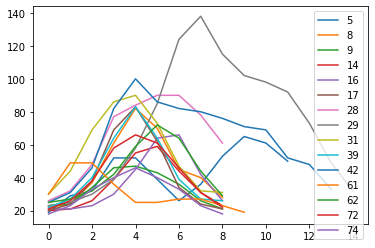

In [508]:
to_test = []
for k, b in brightnesses.items():
    if len(b) > 8:
        plt.plot(b, label=f"{k}")
        to_test.append(k)
plt.legend()

In [509]:
# # i = 50 # Should be 2
# i = 71 # Should be 1

# y = brightnesses[i]
# x = neuron_planes[i]
# plt.plot(x, y)

In [510]:
from lmfit.models import GaussianModel, ConstantModel

In [511]:
np.mean(y)

48.90909090909091

In [528]:
def aicc_correction(p, n):
    return 2*p*(p+1) / (n-p-1)

def compare_gaussian_fits(x, y):

    min_separation = 2
    # x, y = np.array(x), np.array(y)
    x, y = np.arange(len(x)), np.array(y)
    
    background = 14
    y -= background

    # background = ConstantModel()
    # pars = background.make_params()
    # pars['c'].set(value=np.min(y), min=14)
    # background = 14

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())

    pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=2.0, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())

    pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
    pars['g2_sigma'].set(value=2.0, min=1, max=3)
    pars['g2_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1 + gauss2# + background

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    # print(out.fit_report(min_correl=0.5))

#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
#     axes[1].legend()

#     plt.show()

    results_2gauss = out
    

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())
    pars['g1_center'].set(value=len(y) / 2.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=2.0, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].legend()

#     plt.show()

    results_1gauss = out
    
    
#     gauss1 = GaussianModel(prefix='g1_')
#     pars = gauss1.make_params()
#     # pars.update(gauss1.make_params())

#     pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
#     pars['g1_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g1_amplitude'].set(value=np.mean(y), min=0)

#     gauss2 = GaussianModel(prefix='g2_')
#     pars.update(gauss2.make_params())

#     pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g2_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g2_amplitude'].set(value=np.mean(y), min=0)
    
#     gauss3 = GaussianModel(prefix='g3_')
#     pars.update(gauss3.make_params())

#     pars['g3_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g3_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g3_amplitude'].set(value=np.mean(y), min=0)

#     mod = gauss1 + gauss2 + gauss3

#     init = mod.eval(pars, x=x)
#     out = mod.fit(y, pars, x=x)
    
#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
#     axes[1].plot(x, comps['g3_'], '--', label='Gaussian component 3')
#     axes[1].legend()

#     plt.show()

    results_3gauss = out
    
    return results_1gauss, results_2gauss, results_3gauss, axes


from segmentation.util.utils_postprocessing import calc_split_point_from_gaussians
def calc_split_point_from_gaussians2(result):
    peak1 = result.values['g1_center']
    peak2 = result.values['g2_center']
    y = result.data
    
    split_point = calc_split_point_from_gaussians(result)
    # split_point = calc_split_point_from_gaussians([int(np.floor(peak1)), int(np.ceil(peak2))], y)
    return split_point

Testing neuron 5
TWO GAUSSIANS


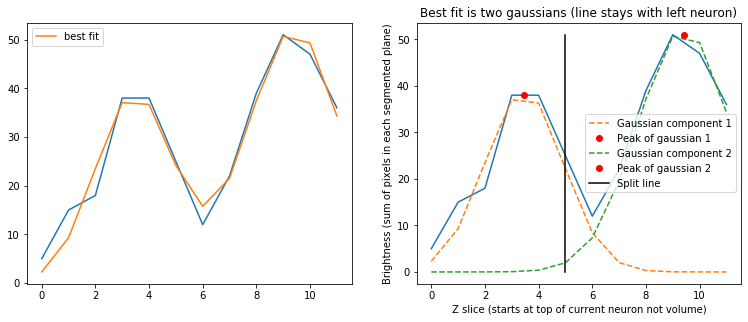

5


In [534]:
# to_test

from segmentation.util.util_curve_fitting import plot_gaussians, get_best_model_using_aicc, calculate_multi_gaussian_fits

for i in to_test:
    print("===================================================")
    print(f"Testing neuron {i}")
    print("===================================================")
    y = brightnesses[i]
    x = neuron_planes[i]

    # res1, res2, res3, axes = compare_gaussian_fits(x, y)
    list_of_models = calculate_multi_gaussian_fits(y, background=14)
    # list_of_models = [res1, res2]
    i_best = get_best_model_using_aicc(list_of_models)
    
    # aic1, aic2, aic3 = res1.aic, res2.aic, res3.aic
    # aicc1 = aic1 + aicc_correction(res1.nvarys, len(y))
    # aicc2 = aic2 + aicc_correction(res2.nvarys, len(y))
    # aicc3 = aic3 + aicc_correction(res3.nvarys, len(y))
    
    print("===================================================")
    if i_best == 0:
        print("ONE GAUSSIAN")
        split = None
    elif i_best == 1:
        print("TWO GAUSSIANS")
        # Also plot split point, IF ANY
        split = calc_split_point_from_gaussians(list_of_models[1])
    else:
        print("THREE GAUSSIANS")

    plot_gaussians(list_of_models[1], split)
    # axes[1].plot([split, split], [0, np.max(y)])
    print(split)
    # if split is None:
    #     break
    # plt.show()
    
    # print(aic1, aic2, aic3)
    # print(aicc1, aicc2, aicc3)
    print("===================================================")
    break

In [535]:
# calc_split_point_from_gaussians(res2)

In [517]:
result = res2


y = result.data
x = np.arange(len(y))

g1 = result.eval_components(x=np.array(x))['g1_']
g2 = result.eval_components(x=np.array(x))['g2_']
diff = np.array(np.abs(g1 - g2))

peak1 = result.values['g1_center']
peak2 = result.values['g2_center']
if peak1 > peak2:
    peak1, peak2 = peak2, peak1
# print(peak1, peak2)
peaks_of_gaussians = [int(np.floor(peak1)), int(np.ceil(peak2))]

ind = peaks_of_gaussians[0] + np.array(range(0, peaks_of_gaussians[1] + 1))
ind = np.clip(ind, 0, len(diff)-1)
inter_peak_diff = np.array(diff[ind])

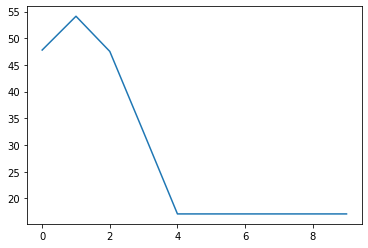

In [518]:
plt.plot(inter_peak_diff)

In [522]:
peak1, peak2

(4.989228237998518, 8.999960333112343)

In [520]:
find_peaks(inter_peak_diff)

(array([1]), {})

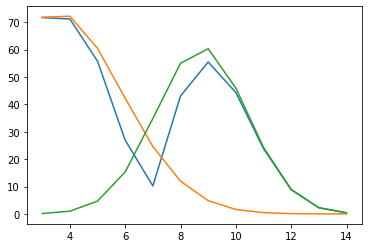

In [425]:
g1 = res2.eval_components(x=np.array(x))['g1_']
g2 = res2.eval_components(x=np.array(x))['g2_']
diff = np.array(np.abs(g1 - g2))

plt.plot(x, diff)
plt.plot(x, g1)
plt.plot(x, g2)

In [432]:

peak1 = res2.values['g1_center'] - x[0]
peak2 = res2.values['g2_center'] - x[0]
print(peak1, peak2)
peaks_of_gaussians = [int(np.floor(peak1)), int(np.ceil(peak2))]

ind = peaks_of_gaussians[0] + np.array(range(0,peaks_of_gaussians[1]+1))
inter_peak_diff = np.array(diff[ind])

0.5263479165951477 5.7526590168393295


In [536]:
# from scipy.signal._peak_finding import find_peaks
# find_peaks(inter_peak_diff)[0][0]

In [537]:
# res2.data

# Debug package functions

In [599]:
project_path = "/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/project_config.yaml"
from DLC_for_WBFM.utils.projects.project_config_classes import ModularProjectConfig
from segmentation.util.utils_config_files import _unpack_config_file
from segmentation.util.utils_pipeline import *
from segmentation.util.utils_pipeline import _only_postprocess2d
from DLC_for_WBFM.utils.projects.utils_project import safe_cd

project_cfg = ModularProjectConfig(project_path)

In [613]:
segment_cfg = project_cfg.get_segmentation_config()
continue_from_frame = None
DEBUG=False

In [614]:
with safe_cd(project_cfg.project_dir):
    frame_list, mask_fname, metadata_fname, num_frames, _, verbose, video_path, zero_out_borders, all_bounding_boxes = _unpack_config_file(
        segment_cfg, project_cfg, DEBUG)

    check_all_needed_data_for_step(project_cfg.self_path, 2)
    masks_zarr = zarr.open(mask_fname)
    old_masks = np.array(masks_zarr[:10])
    masks_zarr = np.array(masks_zarr[:10])
    
    video_dat = zarr.open(video_path)

    opt_postprocessing = segment_cfg.config['postprocessing_params']  # Unique to 2d
    opt_postprocessing['already_stitched'] = True
    opt = {'masks_zarr': masks_zarr, 'opt_postprocessing': opt_postprocessing,
           'verbose': verbose,
           'all_bounding_boxes': all_bounding_boxes}
    if continue_from_frame is None:
        # Note that this does NOT have a separate 'do first volume' function
        continue_from_frame = 0

In [615]:
opt['verbose'] = 2

for i_both in enumerate(frame_list[continue_from_frame:]):
    i_out, i_vol = i_both
    print(i_both)
    _only_postprocess2d(i_out + continue_from_frame, i_vol, video_dat=video_dat, **opt)

(0, 0)
Starting preprocessing with 148 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 148
After stitching: 148
After splitting: 150
After short neuron removal: 150
After border removal: 151
Postprocessing finished
(1, 1)
Starting preprocessing with 140 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 140
After stitching: 140
After splitting: 140
After short neuron removal: 140
After border removal: 141
Postprocessing finished
(2, 2)
Starting preprocessing with 139 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 139
After stitching: 139
After splitting: 139
After short neuron removal: 139
After border removal: 140
Postprocessing finished
(3, 3)
Starting preprocessing with 148 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 148
After stitching: 148
After splitting: 148
After short neuron removal

In [610]:
frame_list = list(range(10))
continue_from_frame = 0

In [619]:
all_bounding_boxes

In [616]:
v = napari.view_labels(masks_zarr[:10])
v.add_labels(old_masks)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'old_masks' at 0x7fb7d081d210>

In [603]:
i = 0

np.unique(np.where(np.abs(masks_zarr[i] - old_masks[i]) > 0, old_masks[i], -1))

array([-1], dtype=int32)

In [604]:
np.unique(np.where(old_masks[i]==13, masks_zarr[i], -1))

array([-1, 13], dtype=int32)

NameError: name 'df_sparse' is not defined

# View results from function

In [629]:
fname = '/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/1-segmentation/masks.zarr'
z = zarr.open(fname)
v = napari.view_labels(z)

fname = '/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/1-segmentation/masks-backup.zarr'
z2 = zarr.open(fname)
v = v.add_labels(z2)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


In [627]:
np.array(z2[0, ...]).shape

(23, 650, 900)

In [183]:
from sklearn.model_selection import cross_val_score, cross_validate

In [185]:
# def residual_score(model, x, y):
#     return np.linalg.norm(model.eval(x=x) - y)

# scores = cross_validate(mod, x, y, cv=5, scoring=residual_score)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [181]:
mod.eval(x=x) - y

array([-17.20211544, -17.51605855, -20.89201807, -24.9911363 ,
       -32.99973234, -36.99999703, -37.99999999, -35.        ,
       -28.        , -22.        , -19.        ])

In [217]:
from sklearn import mixture
from sklearn.preprocessing import StandardScaler


In [235]:
x2 = x.reshape(-1,1)
scaler = StandardScaler()
y2 = scaler.fit_transform(y.reshape(-1,1))
y2 -= np.min(y2)

gmm1 = mixture.GaussianMixture(
    n_components=1, means_init=np.array([[len(y)/2.0]]).T, covariance_type='diag'
)
gmm1.fit(y2)
gmm1.bic(y2)

36.012438276105044

In [236]:
gmm2 = mixture.GaussianMixture(
    n_components=2, means_init=np.array([[len(y)/4.0, 3*len(y)/4.0]]).T, covariance_type='diag'
)
gmm2.fit(y2)
gmm2.bic(y2)

43.20612388656385

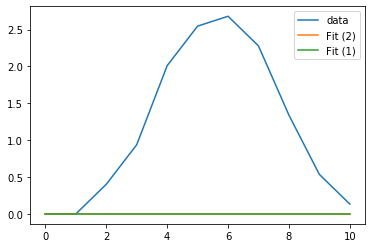

In [237]:
x2 = x.reshape(-1,1)

plt.plot(x2, y2, label="data")
plt.plot(gmm2.predict(x2), label="Fit (2)")
plt.plot(gmm1.predict(x2), label="Fit (1)")
plt.legend()